## Accounting for substrate

Often in heat diffusion settings, the substrate is disregarded and only the target layer is considered. We suggest to also account for the substate since it is an important channel for heat diffusion and therefore influences the dynamics of the target layer to a large extent. 

However, we want to note, that if the parameters for the substrate layer are not available, then one can think of changing the boundary condition on the right-hand side to *Neumann*- type. 
This can be done via: 

`
sim.changeBC_Type(system1,"right","neumann")
sim.changeBC_Type(system2,"right","neumann")
sim.changeBC_Value(system1,"right",1)
sim.changeBC_Value(system2,"right",1)
`

The advantage of this method is that we can create a heat flux directed outward of the target material by imposing a certain flux on the boundary. The disadvantage is, that we have no precise knowledge about the value of the imposed flux, hence setting it here to `1` is just an arbitrary choice. 

This is why we **recommend the following**:
* Set up a 2TM simulation for two layers
* Account for the substrate with a high spatial resolution at the target- substrate edge and then decrease the number of interpolation points with the distance to the target layer.

### Aim 

* Perform simulations and analyze the effect of the substrate
* Suggest one way to "correctly" implement the substrate

As always, the workflow is **Source** $\rightarrow$ **Simulation** $\rightarrow$ **Visualization**

In [1]:
from NTMpy import NTMpy as ntm
import numpy as np
from matplotlib import pyplot as plt
import numericalunits as u
u.reset_units('SI')

### Define a Source

In [2]:
s                           = ntm.source()
s.spaceprofile              = "TMM"
s.timeprofile               = "Gaussian"
# Set the Full Width at Half Maximum (width of the Gaussian)
s.FWHM          = 0.1*u.ps 
# Set the fluence of the laser pulse (area under the Gaussian)
s.fluence       = 6*u.mJ/u.cm**2 
# Set the time of the Gaussian peak 
s.t0            = 1*u.ps   
# Set the wavelength in vacuum in nm
s.lambda_vac    = 400   
#Set the incident angle in rad (0 is perpendicular to the surface)
s.theta_in      = np.pi/4  
s.polarization  = 'p'

### Parameters Pt and Si- materials

In [3]:
# Platinum
length_Pt   = 10*u.nm
n_Pt        = 1.7176+2.844j # at 400nm
k_el_Pt     = 72*u.W/(u.m*u.K)# Same for electrons and lattice
rho_Pt      = 1e3*21*u.kg/(u.m**3)
C_el_Pt     = lambda Te: (740*u.J/(u.m**3*u.K**2))/(1e3*21*u.kg/(u.m**3)) *Te
C_lat_Pt    = 2.78e6*u.J/(u.m**3*u.K**2)/rho_Pt
G_Pt        = 2.5e17*u.W/(u.m**3*u.K) 

# Silicon
n_Si        = 5.5674+0.38612j #at 400nm
k_el_Si     = 130#W/(m*K);
k_lat_Si    = lambda T: np.piecewise(T,[T<=120.7,T>120.7],\
                                      [lambda T: 100*(0.09*T**3*(0.016*np.exp(-0.05*T)+np.exp(-0.14*T))), 
                                       lambda T: 100*(13*1e3*T**(-1.6))])
rho_Si      = 2.32e3#kg/(m**3)
C_el_Si     = lambda Te: 150/rho_Si *Te
C_lat_Si    = 1.6e6/rho_Si
G_Si        = 1e17*18

### Set up a simulation for a 2- System case

Note that here the Platinum target layer and the Silicon substrate are very different in length. Still, the way the algorithm is designed, every layer will get a certain number of *collocation* points. Those can be uniformly changed by `sim.temp_data.collocpts = int_number`.
However, the spacial resolution of Platinum is very high, with respect to the one of Silicon, simply because their length is so different.

In [4]:
sim = ntm.simulation(2,s)
#lengt,refractive index,conductivity[el,la],heatCapacity [el,lat],density,linearCoupling 
sim.addLayer(length_Pt,n_Pt,[k_el_Pt,k_el_Pt],[C_el_Pt,C_lat_Pt],rho_Pt,[G_Pt])  
sim.addLayer(5000*u.nm,n_Si,[k_el_Si,k_lat_Si],[C_el_Si,C_lat_Si],rho_Si,[G_Si])
sim.final_time = 7*u.ps
[x,t,Tmap] = sim.run()
T_e = Tmap[0]; T_l = Tmap[1] 

-----------------------------------------------------------
 No specific time constant has been indicated. 
 The stability region has been calculated and an appropriate timestep has been chosen.
 Timestep = 5.37e-16 s
-----------------------------------------------------------
-----------------------------------------------------------
Transfer matrix absorption profile and a Gaussian time profile is taken into account for the source.
Length of every layer has to be given in units of meter.
-----------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████| 13040/13040 [00:04<00:00, 3131.65it/s]


-----------------------------------------------------------
Heat diffusion in a coupled electron-lattice system has been simulated
Eleapsed time in E.E.- loop: 4.173905372619629
-----------------------------------------------------------


Now let us inspect the result, by exponentially giving weight to the averaged temperature and subtracting the initial temperature $T_{e,l}(x,t=0) = 300$, since we are only interested int he change $\Delta T_e$ and $\Delta T_l$. 

In [5]:
pen_depth = 10*u.nm #Optical penetration depth of probe laser
exp_weights = np.exp(-x/pen_depth)
avT_E_w = np.average(T_e,axis = 1, weights = exp_weights)
avT_L_w = np.average(T_l,axis = 1, weights = exp_weights)
avT_tot = (avT_E_w + avT_L_w - 600)

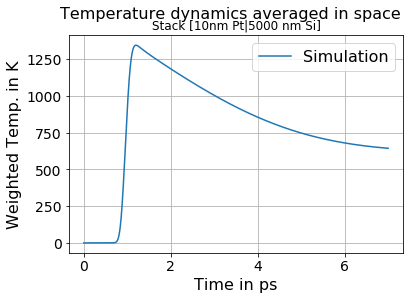

In [6]:
plt.figure()
plt.suptitle("Temperature dynamics averaged in space",fontsize = 16)
plt.title("Stack [10nm Pt|5000 nm Si]")
plt.xlabel("Time in ps",fontsize = 16);
plt.ylabel(r"Weighted Temp. in K",fontsize = 16)
plt.plot(t*(1/u.ps),avT_tot,label = f"Simulation")
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.legend(loc = "upper right",fontsize = 16)
plt.grid()

Now let us consider the same simulation again **but** instead of only stacking up one "long" layer of the substrate, we **put multiple layers**, with increasing length after the Pt- target. 

This will increase the spatial resolution close to the Pt|Si- edge, where modeling the diffusion accurately is important since it is an important channel for the heat dynamics.  

In [7]:
sim = ntm.simulation(2,s)
sim.addLayer(length_Pt,n_Pt,[k_el_Pt,k_el_Pt],[C_el_Pt,C_lat_Pt],rho_Pt,[G_Pt])  
sim.addLayer(10*u.nm,n_Si,[k_el_Si,k_lat_Si],[C_el_Si,C_lat_Si],rho_Si,[G_Si])
sim.addLayer(20*u.nm,n_Si,[k_el_Si,k_lat_Si],[C_el_Si,C_lat_Si],rho_Si,[G_Si])
sim.addLayer(100*u.nm,n_Si,[k_el_Si,k_lat_Si],[C_el_Si,C_lat_Si],rho_Si,[G_Si])
sim.addLayer(4870*u.nm,n_Si,[k_el_Si,k_lat_Si],[C_el_Si,C_lat_Si],rho_Si,[G_Si])
sim.final_time = 7*u.ps
[x,t,Tmap] = sim.run()
T_e = Tmap[0]; T_l = Tmap[1] 

-----------------------------------------------------------
 No specific time constant has been indicated. 
 The stability region has been calculated and an appropriate timestep has been chosen.
 Timestep = 6.02e-17 s
-----------------------------------------------------------
-----------------------------------------------------------
Transfer matrix absorption profile and a Gaussian time profile is taken into account for the source.
Length of every layer has to be given in units of meter.
-----------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████| 116283/116283 [01:48<00:00, 1069.05it/s]


-----------------------------------------------------------
Heat diffusion in a coupled electron-lattice system has been simulated
Eleapsed time in E.E.- loop: 108.77545142173767
-----------------------------------------------------------


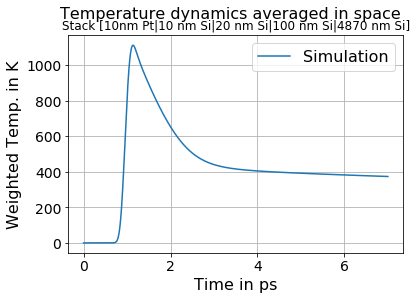

In [8]:
pen_depth = 10*u.nm 
exp_weights = np.exp(-x/pen_depth)
avT_E_w = np.average(T_e,axis = 1, weights = exp_weights)
avT_L_w = np.average(T_l,axis = 1, weights = exp_weights)
avT_tot = (avT_E_w + avT_L_w - 600)

plt.figure()
plt.suptitle("Temperature dynamics averaged in space",fontsize = 16)
plt.title("Stack [10nm Pt|10 nm Si|20 nm Si|100 nm Si|4870 nm Si]")
plt.xlabel("Time in ps",fontsize = 16);
plt.ylabel(r"Weighted Temp. in K",fontsize = 16)
plt.plot(t*(1/u.ps),avT_tot,label = f"Simulation")
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.legend(loc = "upper right",fontsize = 16)
plt.grid()

As expected, now the averaged temperature decays faster after the laser excitation. This indicates that the relaxation of the system happens on a faster time scale,  which is due to more accurate modeling of the substrate layer, by dividing it into several **pice- wise homogeneous layers of the same type**.

Note that further increase of resolution, i.e. either making the Silicon layers even smaller or putting more of the short Si- layers after the Pt- target, does not significantly change the result. This indicates that by this approach we can converge to the "correct" solution with respect to the physical nature of the problem. 